In [65]:
import os
import pandas as pd
import numpy as np
import sys
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import LambdaLR
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
import argparse
import copy
import datetime
import matplotlib.pyplot as plt

In [66]:
run_config = dict(
    features_to_keep = ['ESO INS4 FILT3 NAME', 'ESO INS4 OPTI22 NAME', \
        'ESO AOS VISWFS MODE', 'ESO TEL AMBI WINDSP', 'ESO TEL AMBI RHUM', \
            'HIERARCH ESO INS4 TEMP422 VAL', 'HIERARCH ESO TEL TH M1 TEMP', 'HIERARCH ESO TEL AMBI TEMP', \
                'ESO DET NDIT', 'ESO DET SEQ1 DIT', 'SIMBAD_FLUX_G', 'SIMBAD_FLUX_H', 'SEEING_MEDIAN', \
                    'SEEING_STD', 'COHERENCE_TIME_MEDIAN', 'COHERENCE_TIME_STD', 'SCFOVROT', 'SEPARATION', 'NSIGMA_CONTRAST'],
    categorical_features = ['ESO INS4 FILT3 NAME', 'ESO INS4 OPTI22 NAME', 'ESO AOS VISWFS MODE'],
    random_state = 42,
    separation_size = 124
)

In [67]:
# Define the model
class MLP(nn.Sequential):
    def __init__(self, input_features, output_features, hidden_features, num_hidden_layers):
        layers = []
        layers.append(nn.Linear(input_features, hidden_features))
        layers.append(nn.ReLU())
        
        for _ in range(num_hidden_layers - 1):
            layers.append(nn.Linear(hidden_features, hidden_features))
            layers.append(nn.ReLU())
        
        layers.append(nn.Linear(hidden_features, output_features))
        
        super().__init__(*layers)

criterion = nn.MSELoss()

In [68]:
def get_file_names(path):
    """"
    Returns a list of file names in a directory
    """
    return [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]

print(get_file_names("Meetings notes"))

['TODO.txt', '221027 (Julien).txt', '221118 (Olivier, Elodie, Gilles).txt']


In [69]:
def reshape_dataframe(df, vec_column_name_list):
    """
    Reshape a dataframe containing vectors in order to have one row per element of the vectors.
    The metadata of the row is repeated for each element of the vectors.

    Parameters
    ----------
    df : pandas.DataFrame
        The dataframe to reshape
    vec_column_name_list : list
        The list of the columns containing vectors

    Returns
    -------
    df_reshaped : pandas.DataFrame
        The reshaped dataframe
    """

    columns = df.columns
    reshape_dataframe = {}

    # Initialize the dictionary
    for column in columns:
        reshape_dataframe[column] = []

    # Fill the dictionary
    for index, row in df.iterrows():
        # Create a dictionnary with only the metadata of the row, that is without the columns in vec_column_name_list
        meta_dict = row.drop(vec_column_name_list).to_dict()

        # Check whether the dimensions of the vectors are the same
        for column in vec_column_name_list:
            if len(row[column]) != len(row[vec_column_name_list[0]]):
                raise ValueError("The dimensions of the vectors are not the same")

        for i in range(len(row[vec_column_name_list[0]])):
            # Add the metadata to the dictionary
            for key, value in meta_dict.items():
                reshape_dataframe[key].append(value)

            # Add the vector to the dictionary
            for column in vec_column_name_list:
                reshape_dataframe[column].append(row[column][i])

    # Create a dataframe from the dictionary
    df_reshaped = pd.DataFrame(reshape_dataframe)
    return df_reshaped

In [70]:
def make_data_vector(df_AD, config):

    # Check whether df_AD contains 'SEPARATION' and 'NSIGMA_CONTRAST'
    if 'SEPARATION' not in df_AD.columns:
        raise ValueError("df_AD must contain the column 'SEPARATION'")
    if 'NSIGMA_CONTRAST' not in df_AD.columns:
        raise ValueError("df_AD must contain the column 'NSIGMA_CONTRAST'")

    # The numerical features are the ones that are not categorical
    numerical_features = list(set(config.features_to_keep) - set(config.categorical_features) - set(['SEPARATION', 'NSIGMA_CONTRAST']))

    # Get a dataframe containing only the columns we want to keep
    df_AD = df_AD[config.features_to_keep]

    # Convert the strings to numbers in order to transform it into a tensor
    df_AD.loc[:, 'ESO INS4 FILT3 NAME'] = pd.factorize(df_AD['ESO INS4 FILT3 NAME'])[0]
    df_AD.loc[:, 'ESO INS4 OPTI22 NAME'] = pd.factorize(df_AD['ESO INS4 OPTI22 NAME'])[0]
    df_AD.loc[:, 'ESO AOS VISWFS MODE'] = pd.factorize(df_AD['ESO AOS VISWFS MODE'])[0]

    # Get values of separation between 0 and 1
    separation = np.array(df_AD['SEPARATION'][0])
    separation = separation / np.max(separation)

    # Replace every separation vectors with the new one
    df_AD.loc[:, 'SEPARATION'] = df_AD['SEPARATION'].apply(lambda x: np.array(x) / np.max(x))

    # Split the data into train, validation and test sets
    train = df_AD.sample(frac=0.8, random_state=config.random_state)
    validation = df_AD.drop(train.index)
    test = validation.sample(frac=0.5, random_state=config.random_state)
    validation = validation.drop(test.index)

    # Transform the NaN values into the median of the column of the training set (only for the numerical features)
    imp = KNNImputer(n_neighbors=5, weights="uniform")
    train[numerical_features] = imp.fit_transform(train[numerical_features])
    test[numerical_features] = imp.transform(test[numerical_features])
    validation[numerical_features] = imp.transform(validation[numerical_features])

    # Split the data into features and labels
    x_train = train.drop(['NSIGMA_CONTRAST', 'SEPARATION'], axis=1) # Drop SEPARATION in order not to have a vector as input
    y_train = train['NSIGMA_CONTRAST']

    x_test = test.drop(['NSIGMA_CONTRAST', 'SEPARATION'], axis=1)
    y_test = test['NSIGMA_CONTRAST']

    x_validation = validation.drop(['NSIGMA_CONTRAST', 'SEPARATION'], axis=1)
    y_validation = validation['NSIGMA_CONTRAST']

    # Standardize the data
    scaler = StandardScaler()
    x_train[numerical_features] = scaler.fit_transform(x_train[numerical_features])
    x_test[numerical_features] = scaler.transform(x_test[numerical_features])
    x_validation[numerical_features] = scaler.transform(x_validation[numerical_features])

    # Convert the dataframes to numpy arrays
    x_train = (x_train.values).astype(np.float32)
    y_train = np.array(y_train.tolist()).astype(np.float32)
    x_test = (x_test.values).astype(np.float32)
    y_test = np.array(y_test.tolist()).astype(np.float32)
    x_validation = (x_validation.values).astype(np.float32)
    y_validation = np.array(y_validation.tolist()).astype(np.float32)

    return x_train, np.log10(y_train), x_test, np.log10(y_test), x_validation, np.log10(y_validation)

In [71]:
def make_data_single(df_AD, config):

    # Check whether df_AD contains 'SEPARATION' and 'NSIGMA_CONTRAST'
    if 'SEPARATION' not in df_AD.columns:
        raise ValueError("df_AD must contain the column 'SEPARATION'")
    if 'NSIGMA_CONTRAST' not in df_AD.columns:
        raise ValueError("df_AD must contain the column 'NSIGMA_CONTRAST'")

    # The numerical features are the ones that are not categorical
    numerical_features = list(set(config.features_to_keep) - set(config.categorical_features) - set(['SEPARATION', 'NSIGMA_CONTRAST']))

    # Get a dataframe containing only the columns we want to keep
    df_AD = df_AD[config.features_to_keep]

    # Convert the strings to numbers in order to transform it into a tensor
    df_AD.loc[:, 'ESO INS4 FILT3 NAME'] = pd.factorize(df_AD['ESO INS4 FILT3 NAME'])[0]
    df_AD.loc[:, 'ESO INS4 OPTI22 NAME'] = pd.factorize(df_AD['ESO INS4 OPTI22 NAME'])[0]
    df_AD.loc[:, 'ESO AOS VISWFS MODE'] = pd.factorize(df_AD['ESO AOS VISWFS MODE'])[0]

    # Get values of separation between 0 and 1
    separation = np.array(df_AD['SEPARATION'][0])
    separation = separation / np.max(separation)

    # Replace every separation vectors with the new one
    df_AD.loc[:, 'SEPARATION'] = df_AD['SEPARATION'].apply(lambda x: np.array(x) / np.max(x))

    # Split the data into train, validation and test sets
    train = df_AD.sample(frac=0.8, random_state=config.random_state)
    validation = df_AD.drop(train.index)
    test = validation.sample(frac=0.5, random_state=config.random_state)
    validation = validation.drop(test.index)

    # Transform the NaN values into the median of the column of the training set (only for the numerical features)
    imp = KNNImputer(n_neighbors=5, weights='uniform')
    train[numerical_features] = imp.fit_transform(train[numerical_features])
    test[numerical_features] = imp.transform(test[numerical_features])
    validation[numerical_features] = imp.transform(validation[numerical_features])

    # Reshape the dataframes (note that the reshape is done after the train/test split to avoid data leakage)
    train = reshape_dataframe(train, ['SEPARATION', 'NSIGMA_CONTRAST'])
    test = reshape_dataframe(test, ['SEPARATION', 'NSIGMA_CONTRAST'])
    validation = reshape_dataframe(validation, ['SEPARATION', 'NSIGMA_CONTRAST'])

    # Split the data into features and labels
    x_train = train.drop(['NSIGMA_CONTRAST'], axis=1)
    y_train = train['NSIGMA_CONTRAST']

    x_test = test.drop(['NSIGMA_CONTRAST'], axis=1)
    y_test = test['NSIGMA_CONTRAST']

    x_validation = validation.drop(['NSIGMA_CONTRAST'], axis=1)
    y_validation = validation['NSIGMA_CONTRAST']

    # Standardize the data
    scaler = StandardScaler()
    x_train[numerical_features] = scaler.fit_transform(x_train[numerical_features])
    x_test[numerical_features] = scaler.transform(x_test[numerical_features])
    x_validation[numerical_features] = scaler.transform(x_validation[numerical_features])

    # Convert the dataframes to numpy arrays
    x_train = (x_train.values).astype(np.float32)
    y_train = np.array(y_train.tolist()).astype(np.float32)
    x_test = (x_test.values).astype(np.float32)
    y_test = np.array(y_test.tolist()).astype(np.float32)
    x_validation = (x_validation.values).astype(np.float32)
    y_validation = np.array(y_validation.tolist()).astype(np.float32)

    return x_train, np.log10(y_train), x_test, np.log10(y_test), x_validation, np.log10(y_validation)

In [72]:
df_AD = pd.read_pickle('Dataset_creation/df_AD_timestamps.pkl')
x_train_single, y_train_single, x_test_single, y_test_single, x_validation_single, y_validation_single = make_data_single(df_AD, argparse.Namespace(**run_config))
x_train_vector, y_train_vector, x_test_vector, y_test_vector, x_validation_vector, y_validation_vector = make_data_vector(df_AD, argparse.Namespace(**run_config))

# Convert to tensors 
x_train_single_tensor = torch.tensor(x_train_single, dtype=torch.float32)
y_train_single_tensor = torch.tensor(y_train_single, dtype=torch.float32)
x_test_single_tensor = torch.tensor(x_test_single, dtype=torch.float32)
y_test_single_tensor = torch.tensor(y_test_single, dtype=torch.float32)
x_validation_single_tensor = torch.tensor(x_validation_single, dtype=torch.float32)
y_validation_single_tensor = torch.tensor(y_validation_single, dtype=torch.float32)

x_train_vector_tensor = torch.tensor(x_train_vector, dtype=torch.float32)
y_train_vector_tensor = torch.tensor(y_train_vector, dtype=torch.float32)
x_test_vector_tensor = torch.tensor(x_test_vector, dtype=torch.float32)
y_test_vector_tensor = torch.tensor(y_test_vector, dtype=torch.float32)
x_validation_vector_tensor = torch.tensor(x_validation_vector, dtype=torch.float32)
y_validation_vector_tensor = torch.tensor(y_validation_vector, dtype=torch.float32)

Validation loss for MLP_single_nsigma_input_size_18_hidden_size_512_n_hidden_layers_10_2023_10_2_18_22_21.pth: 3.7056117057800293
Validation loss for MLP_vector_nsigma_input_size_17_hidden_size_512_n_hidden_layers_10_2023_10_2_18_22_2.pth: 2.911332845687866


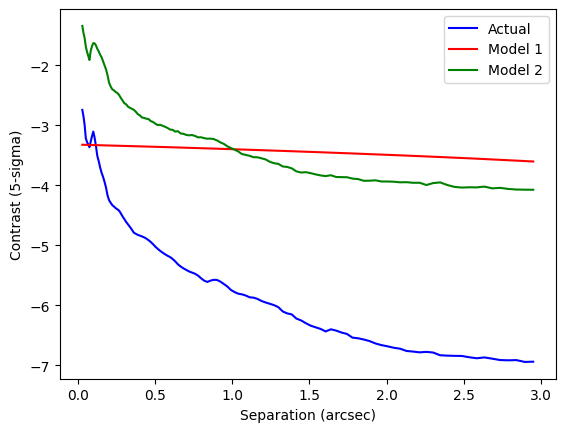

In [73]:
obs_id = 0

path = 'TO_PLOT/'
# Get the model names
model_names = get_file_names(path)

separation = np.array(df_AD['SEPARATION'][obs_id])
contrast = y_test_vector[obs_id]

plt.plot(separation, contrast, color='blue', label='Actual')

model_id = 0

# Load the models
for name in model_names:
    if name.startswith('MLP'):
        # Retrieve the input size 
        input_size = int(name.split('_input_size_')[1].split('_')[0])
        # Retrieve the number of hidden layers
        hidden_layers = int(name.split('_n_hidden_layers_')[1].split('_')[0])
        # Retrieve the number of hidden units
        hidden_units = int(name.split('_hidden_size_')[1].split('_')[0])
        # Retrieve the output size
        if name.split('_')[1] == 'single':
            output_size = 1
        elif name.split('_')[1] == 'vector':
            output_size = 124
        else:
            raise ValueError('Unknown output size')

        # Create the model
        model = MLP(input_size, output_size, hidden_units, hidden_layers)

        # load the state dict
        model.load_state_dict(torch.load(name))

        # Try and see if the model is well trained on the validation set
        model.eval()
        with torch.no_grad():
            if output_size == 1:
                # Validation to be sure that the model is well trained
                outputs = model(x_validation_single_tensor)
                val_loss = criterion(outputs, y_validation_single_tensor.view(-1, 1)).item()
                # Plot the predictions
                start = obs_id * len(separation)
                stop = start + len(separation)
                outputs = model(x_test_single_tensor[start:stop])
                plt.plot(separation, outputs, color='red', label="Model {}".format(model_id))
            else :
                # Validation to be sure that the model is well trained
                outputs = model(x_validation_vector_tensor)
                val_loss = criterion(outputs, y_validation_vector_tensor).item()
                # Plot the predictions
                outputs = model(x_test_vector_tensor[obs_id])
                plt.plot(separation, outputs, color='green', label="Model {}".format(model_id))

            print(f'Validation loss for {name}: {val_loss}')
    model_id += 1

plt.xlabel('Separation (arcsec)')
plt.ylabel('Contrast (5-sigma)')
plt.legend()
plt.show()